<a href="https://colab.research.google.com/github/marekpiotradamczyk/ml_uwr_23/blob/main/Assignments/Assignment7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Assignment 7

**Submission deadline:**
* **lab session in the week 22-26.1.24**

**Points: 5 points**


Have a look at the following implementation of Decision Tree Classifier. Be aware that for the sake of further simplicity it does not allow for categorical variables as typical Decision Trees do.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class DecisionTreeClassifierScratch:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y, depth=0):
        if depth == self.max_depth or len(set(y)) == 1:
            return {'class': max(set(y), key=list(y).count)}

        # Find the best split
        best_feature, best_threshold = self.find_best_split(X, y)

        if best_feature is None:
            return {'class': max(set(y), key=list(y).count)}

        # Split the dataset
        left_indices = X[best_feature] <= best_threshold
        right_indices = ~left_indices

        # Recursively build the tree
        left_subtree = self.fit(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self.fit(X[right_indices], y[right_indices], depth + 1)

        return {'feature': best_feature, 'threshold': best_threshold,
                'left': left_subtree, 'right': right_subtree}

    def find_best_split(self, X, y):
        best_gini = 1.0
        best_feature = None
        best_threshold = None

        for feature in X.columns:
            thresholds = X[feature].unique()
            for threshold in thresholds:
                left_indices = X[feature] <= threshold
                right_indices = ~left_indices

                gini = self.calculate_gini_impurity(y[left_indices], y[right_indices])

                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def calculate_gini_impurity(self, left_labels, right_labels):
        left_size = len(left_labels)
        right_size = len(right_labels)
        total_size = left_size + right_size

        if total_size == 0:
            return 0

        p_left = left_size / total_size
        p_right = right_size / total_size

        gini_left = 1.0 - sum((np.sum(left_labels == c) / left_size) ** 2 for c in set(left_labels))
        gini_right = 1.0 - sum((np.sum(right_labels == c) / right_size) ** 2 for c in set(right_labels))

        gini_impurity = p_left * gini_left + p_right * gini_right

        return gini_impurity

    def predict_single(self, tree, sample):
        if 'class' in tree:
            return tree['class']

        if sample[tree['feature']] <= tree['threshold']:
            return self.predict_single(tree['left'], sample)
        else:
            return self.predict_single(tree['right'], sample)

    def predict(self, X):
        return [self.predict_single(self.tree, sample) for _, sample in X.iterrows()]


# Load Iris dataset
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target

# Use only two features for visualization purposes
X_iris = iris_df[['petal length (cm)', 'petal width (cm)']]
y_iris = iris_df['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, test_size=0.2, random_state=42)

# Create and train the decision tree classifier from scratch
clf = DecisionTreeClassifierScratch(max_depth=4)
clf.tree = clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")



Accuracy: 1.00


In [40]:
def plot_decision_boundary(X, y, tree, feature_names, title="Decision Boundary"):
    # Plot the decision boundary
    plt.figure(figsize=(8, 6))

    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = np.array(tree.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=feature_names))).reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap='viridis', edgecolor='k', s=40)
    plt.title(title)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.show()

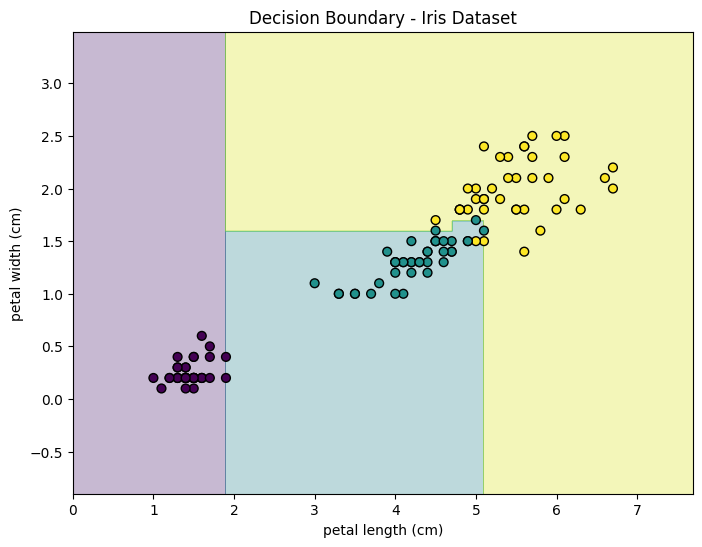

In [41]:
feature_names = X_iris.columns
plot_decision_boundary(X_train, y_train, clf, feature_names, title="Decision Boundary - Iris Dataset")


# Problem 1 [1p]

Based on above implementation, create a Decision Tree model which uses entropy and not Gini. Verify its accuracy on Iris (as above) and plot decision boundaries.

### Decision Tree Model with Entropy

In [42]:
class DecisionTreeWithEntropy:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y, depth=0): # NO CHANGE
        if depth == self.max_depth or len(set(y)) == 1:
            return {'class': max(set(y), key=list(y).count)}

        # Find the best split
        best_feature, best_threshold = self.find_best_split(X, y)

        if best_feature is None:
            return {'class': max(set(y), key=list(y).count)}

        # Split the dataset
        left_indices = X[best_feature] <= best_threshold
        right_indices = ~left_indices

        # Recursively build the tree
        left_subtree = self.fit(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self.fit(X[right_indices], y[right_indices], depth + 1)

        return {'feature': best_feature, 'threshold': best_threshold,
                'left': left_subtree, 'right': right_subtree}

    def find_best_split(self, X, y): # ONLY NAME CHANGE
        best_entropy = 1.0
        best_feature = None
        best_threshold = None

        for feature in X.columns:
            thresholds = X[feature].unique()
            for threshold in thresholds:
                left_indices = X[feature] <= threshold
                right_indices = ~left_indices

                entropy = self.calculate_entropy(y[left_indices], y[right_indices])

                if entropy < best_entropy:
                    best_entropy = entropy
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def calculate_entropy(self, left_labels, right_labels):
        left_size = len(left_labels)
        right_size = len(right_labels)
        total_size = left_size + right_size

        if total_size == 0:
            return 0

        p_left = left_size / total_size
        p_right = right_size / total_size

        entropy_left = 0.0
        entropy_right = 0.0
        for c in set(left_labels):
            pi = np.sum(left_labels == c) / left_size
            entropy_left -= pi * np.log(pi)
        for c in set(right_labels):
            pi = np.sum(right_labels == c) / right_size
            entropy_right -= pi * np.log(pi)

        entropy = p_left * entropy_left + p_right * entropy_right
        return entropy

    def predict_single(self, tree, sample): # NO CHANGE
        if 'class' in tree:
            return tree['class']

        if sample[tree['feature']] <= tree['threshold']:
            return self.predict_single(tree['left'], sample)
        else:
            return self.predict_single(tree['right'], sample)

    def predict(self, X): # NO CHANGE
        return [self.predict_single(self.tree, sample) for _, sample in X.iterrows()]

### Verifying accuracy

In [43]:
# Create and train the decision tree classifier from scratch
clf = DecisionTreeWithEntropy(max_depth=4)
clf.tree = clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


### Plotting decision boundaries

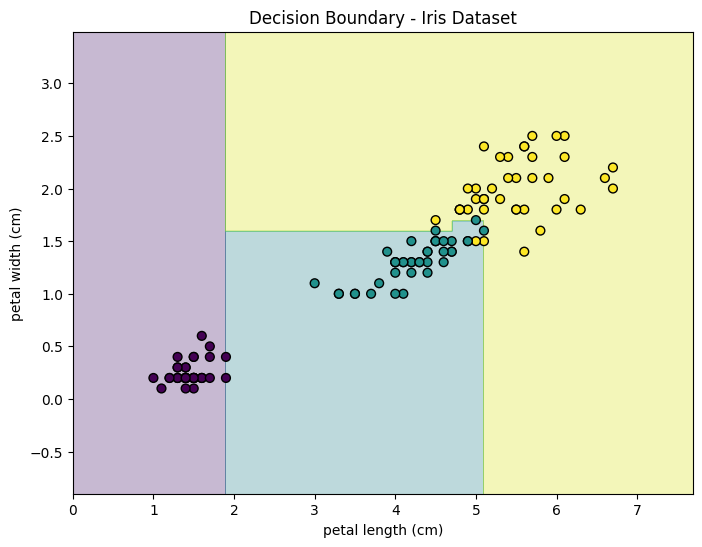

In [44]:
feature_names = X_iris.columns
plot_decision_boundary(X_train, y_train, clf, feature_names, title="Decision Boundary - Iris Dataset")

# Problem 2 [2p]

Default versions of Decision Trees use entropy or Gini to find best features. However, there are is no global objective function that they optimize while training.

Based on the above implementation, please write Decision Tree Classifier that explicitely minimizes the crossentropy function, and makes splits in a greedy way that creates the biggest drop in the Negative Log Likelihood. Verify its accuracy on Iris (as above) and plot decision boundaries.

### Classifier model

In [45]:
class Node:
    def __init__(self, node_type, best_feature_index=None, threshold=None, left=None, right=None):
        self.type: float = node_type # assigned type of node based on majority rule
        self.best_feature_index: str = best_feature_index # feature we use to split tree
        self.threshold: float = threshold # value of that feature we use to split tree
        self.left: Node = left # subtree of values <= than threshold
        self.right: Node = right # subtree of values > than threshold

class DecisionTreeClassifier:
    def __init__(self, max_depth=4, min_size=3):
        self.max_depth = max_depth
        self.min_size = min_size # if node has less kids than that he will stop recursion
        self.root: Node = None

    def most_frequent_value(self, y):
        counts = np.bincount(y.astype(int))
        return np.argmax(counts)

    def split(self, dataset: pd.DataFrame, feature_index: int, threshold: float) -> tuple[pd.DataFrame, pd.DataFrame]:
        dataset_left = pd.DataFrame([row for row in dataset.values if row[feature_index]<=threshold])
        dataset_right = pd.DataFrame([row for row in dataset.values if row[feature_index]>threshold])
        return dataset_left, dataset_right

    def fit(self, X: pd.DataFrame, y: pd.Series, depth=0):
        # this is leaf - max depth, min sample size, only 1 type possible
        if depth == self.max_depth or len(y) < self.min_size or len(set(y)) == 1:
            return Node(self.most_frequent_value(y))

        # Find the best split
        best_feature_index, best_threshold = self.find_best_split(X, y)

        if best_threshold is None: # this is leaf
            return Node(self.most_frequent_value(y))

        # Split the dataset
        dataset = pd.concat([X, y], axis=1)
        dataset_left, dataset_right = self.split(dataset, best_feature_index, best_threshold)

        # Recursively build the tree
        left_subtree = self.fit(dataset_left.iloc[:, :-1], dataset_left.iloc[:, -1], depth + 1)
        right_subtree = self.fit(dataset_right.iloc[:, :-1], dataset_right.iloc[:, -1], depth + 1)

        return Node(self.most_frequent_value(y), best_feature_index, best_threshold, left_subtree, right_subtree)

    def find_best_split(self, X: pd.DataFrame, y: pd.Series) -> tuple[str, float]:
        best_ig = -1.0 # this decides the split - greedy pick of highest information gain
        best_feature_index = None
        best_threshold = None

        for feature_index in range(len(X.columns)):
            feature_values = X.iloc[:, feature_index]
            thresholds = np.unique(feature_values)
            for threshold in thresholds:
                dataset = pd.concat([X, y], axis=1)
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                if len(dataset_left) < 2 or len(dataset_right) < 2:
                    continue
                info_gain = self.calculate_info_gain(y, dataset_left.values[:, -1], dataset_right.values[:, -1])

                if info_gain > best_ig:
                    best_ig = info_gain
                    best_feature_index = feature_index
                    best_threshold = threshold

        return best_feature_index, best_threshold

    def calculate_info_gain(self, yparent, yleft, yright):
        left_weight = len(yleft) / len(yparent)
        right_weight = len(yright) / len(yparent)
        left_entropy = left_weight*self.calculate_entropy(yleft)
        right_entropy = right_weight*self.calculate_entropy(yright)
        gain = self.calculate_entropy(yparent) - left_entropy - right_entropy
        return gain

    def calculate_entropy(self, y):
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def predict_single(self, tree: Node, sample):
        if tree.threshold is None: # this is leaf
            return tree.type

        if sample[tree.best_feature_index] <= tree.threshold:
            return self.predict_single(tree.left, sample)
        else:
            return self.predict_single(tree.right, sample)

    def predict(self, X: pd.DataFrame):
        return [self.predict_single(self.root, sample) for sample in X.values]

### Verifying accuracy

In [48]:
clf = DecisionTreeClassifier(max_depth=4)
clf.root = clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


### Plotting decision boundaries

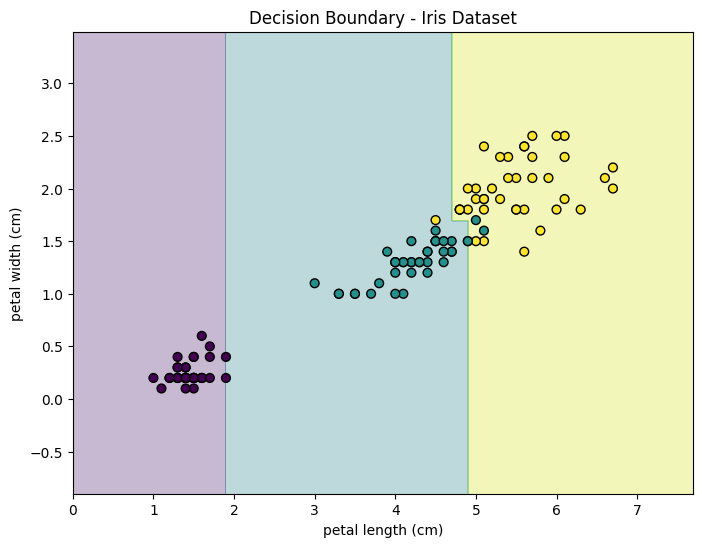

In [49]:
feature_names = X_iris.columns
plot_decision_boundary(X_train, y_train, clf, feature_names, title="Decision Boundary - Iris Dataset")

# Problem 3 [2p]

Based on the above implementation, create a Decision Tree Regressor which greedily chooses a split which locally minimizes MSE the most. Verify its correctness as shown below.

### Tree Regressor from sklearn

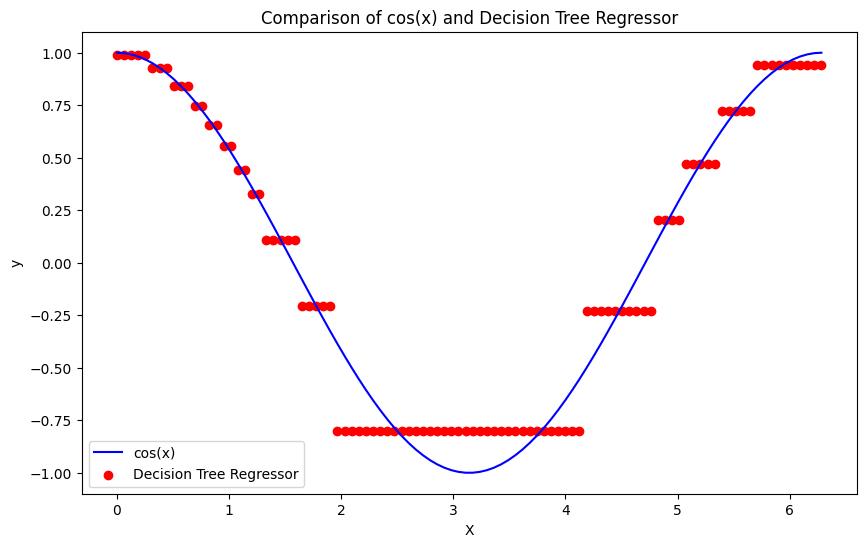

In [50]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# Generate dataset
X = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)  # X values
y = np.cos(X).ravel()  # y values (cos(x))


# Create and train the decision tree regressor from scratch
regressor = DecisionTreeRegressor(max_depth=4)
regressor.fit(X, y)

# Predict on the generated dataset
y_pred = regressor.predict(X)

# Plotting both the cos(x) and the decision tree regressor predictions
plt.figure(figsize=(10, 6))
plt.plot(X, y, label='cos(x)', color='blue')
plt.scatter(X, y_pred, label='Decision Tree Regressor', color='red')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Comparison of cos(x) and Decision Tree Regressor')
plt.legend()
plt.show()



### My tree regressor

Regressor model

In [51]:
class DecisionTreeRegressor:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y, depth=0):
        if depth == self.max_depth or len(set(y)) == 1:
            return {'class': max(set(y), key=list(y).count)}
        # Find the best split
        best_feature, best_threshold = self.find_best_split(X, y)
        if best_feature is None:
            return {'class': max(set(y), key=list(y).count)}

        # Split the dataset
        left_indices = X[:,best_feature] <= best_threshold
        right_indices = ~left_indices

        # Recursively build the tree
        left_subtree = self.fit(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self.fit(X[right_indices], y[right_indices], depth + 1)

        return {'feature': best_feature, 'threshold': best_threshold,
                'left': left_subtree, 'right': right_subtree}

    def find_best_split(self, X, y):
        best_mse = float('inf')
        best_feature = None
        best_threshold = None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = X[:,feature] <= threshold
                right_indices = ~left_indices

                mse = self.calculate_mse(y[left_indices], y[right_indices])

                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def calculate_mse(self, left_labels, right_labels):
        left_size = len(left_labels)
        right_size = len(right_labels)
        total_size = left_size + right_size

        if total_size == 0:
            return 0

        p_left = left_size / total_size
        p_right = right_size / total_size

        mse_left =   np.mean((left_labels - np.mean(left_labels))**2)
        mse_right =  np.mean((right_labels - np.mean(right_labels))**2)

        mse = p_left * mse_left + p_right * mse_right

        return mse

    def predict_single(self, tree, sample):
        if 'class' in tree:
            return tree['class']

        if sample[tree['feature']] <= tree['threshold']:
            return self.predict_single(tree['left'], sample)
        else:
            return self.predict_single(tree['right'], sample)

    def predict(self, X):
        return [self.predict_single(self.tree, sample) for sample in X]

Veryfying my tree regressor

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


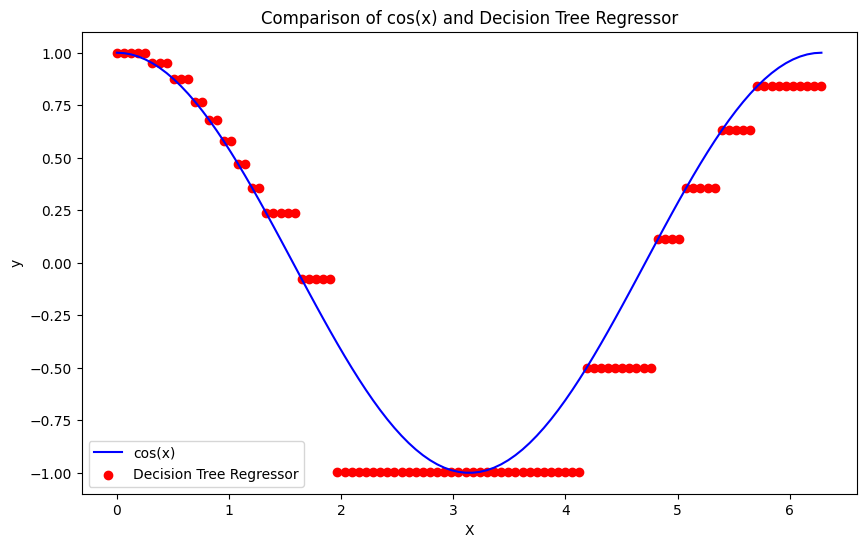

In [52]:
# Generate dataset
X = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)  # X values
y = np.cos(X).ravel()  # y values (cos(x))


# Create and train the decision tree regressor from scratch
regressor4 = DecisionTreeRegressor(max_depth=4)
regressor4.tree = regressor4.fit(X, y)

# Predict on the generated dataset
y_pred = regressor4.predict(X)

# Plotting both the cos(x) and the decision tree regressor predictions
plt.figure(figsize=(10, 6))
plt.plot(X, y, label='cos(x)', color='blue')
plt.scatter(X, y_pred, label='Decision Tree Regressor', color='red')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Comparison of cos(x) and Decision Tree Regressor')
plt.legend()
plt.show()